# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [27]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import re
from numpy import random
import random as rand

from dreaminsg_integrated_model.network_sim_models.interdependencies import *
import dreaminsg_integrated_model.network_sim_models.water.water_network_model as water
import dreaminsg_integrated_model.network_sim_models.power.power_system_model as power
import dreaminsg_integrated_model.network_sim_models.transportation.network as transpo
from dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator_discrete import *
import dreaminsg_integrated_model.results.figures.plots as plots


import dreaminsg_integrated_model.simulation as simulation

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [5]:
network_dir= 'in2'

MAIN_DIR = Path('..')
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/Example_water2.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/Example_power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

#load water_network model
try:
    initial_sim_step = 60
    wn = water.load_water_network(water_file, initial_sim_step)
    total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

#load power systems network
try:
    pn = power.load_power_network(power_file)
    power.run_power_simulation(pn)
    total_base_power_demand = pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum()
except UserWarning:
    print("Error: The power systems file does not exist. No such file or directory: ", power_file)

#load dynamic traffic assignment model
try:
    tn = transpo.Network(f"{transp_folder}/example_net.tntp", f"{transp_folder}/example_trips.tntp", f"{transp_folder}/example_node.tntp")
    print(f"Transportation network successfully loaded from {transp_folder}. Static traffic assignment method will be used to calculate travel times.")
    tn.userEquilibrium("FW", 400, 1e-4, tn.averageExcessCost)
except FileNotFoundError:
    print("Error: The transportation network folder does not exist. No such directory: ", transp_folder)
except AttributeError:
    print("Error: Some required network files not found.")

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\Example_water2.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.
Iteration 1: gap 0.000305: time 0.000998
Iteration 2: gap 0.000000: time 0.003990


## Create a Networkx graph of the integrated infrastructure network.

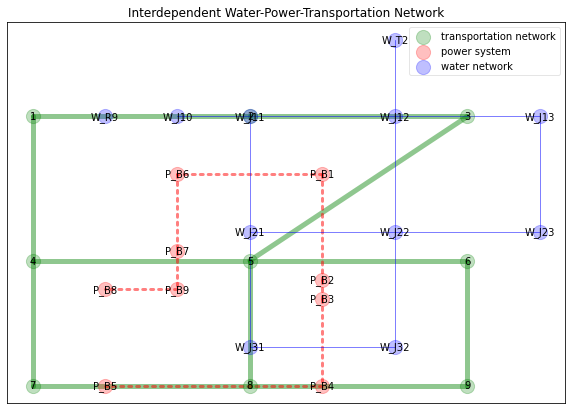

In [6]:
integrated_graph = plots.plot_integrated_network(pn, wn, tn)

## Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [7]:
dependency_table = DependencyTable()

#water - power dependencies stored to wp_table
dependency_table.add_pump_motor_coupling(water_id='W_WP9', power_id='P_MP1')
dependency_table.add_gen_reserv_coupling(water_id='W_R9', power_id='P_G3')
dependency_table.wp_table.head()

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [8]:
#transportation access dependencies saved to access_table
dependency_table.add_transpo_access(integrated_graph)
dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,4,power,Bus,125.00
1,P_B7,5,power,Bus,103.08
2,P_B5,7,power,Bus,100.00
3,P_B4,8,power,Bus,100.00
4,P_B6,2,power,Bus,180.28


## Simulation of interdependent effects using a test scenario
### (a) Scheduling infrastructure disruptions and optimal recovery actions.
Before we run the simulation, we need to specify the simulation parameters and recovery parameters.

In [9]:
#Setting recovery parameters
curr_loc_crew = 8
recovery_rate = 0.05

#Setting simulation parameters
sim_duration = 3600*24
sim_step = initial_sim_step

Now, we have to create a event table that has all the disruptions and recovery actions scheduled in it. For this first, we read the disruptive scenario file having information only about the disruptive events. The we add the disruptive events to the main **event_table**.

In [10]:
# creating test case dataframe
scenario_file = '../dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure_net1.csv'
motor_failure = DisruptionAndRecovery(scenario_file, sim_duration, sim_step, curr_loc_crew)
motor_failure.disruptive_events

#change field name- not failure probability (damage extent)

,time_stamp,components,fail_perc
0,15000,P_MP1,75
1,6000,P_L1,50
2,18000,P_LO1,25


In [11]:
motor_failure.event_table

,time_stamp,components,perf_level
0,0,P_MP1,100
1,0,P_L1,100
2,0,P_LO1,100
3,15000,P_MP1,25
4,6000,P_L1,50
5,18000,P_LO1,75


Now, we identify the optimized recovery strategy (order of restoration/repair) and schedule the recovery actions in the **event_table**. The travel time for the repair crew from current location to the next location is computed using the transportation network model. 

In [12]:
#Simulating repair curves
repair_order =  motor_failure.optimze_recovery_strategy() #Felix' model will be embedded in this method.
print(f"The optimised repair strategy is to schedule repair of failed components in the following order: {repair_order}\n")

if len(repair_order) > 0:
    for index, node in enumerate(repair_order):
        origin_node = node
        compon_infra, compon_notation, compon_code, compon_full = interdependencies.get_compon_details(origin_node)

        if compon_infra == "power":
            recovery_time = power_dict[compon_notation]["repair_time"]*3600
            connected_bus = find_connected_power_node(origin_node, pn)
            nearest_node, near_dist = get_nearest_node(integrated_graph, connected_bus, "transpo_node")
            travel_time = int(round(tn.calculateShortestTravelTime(motor_failure.curr_loc_crew, nearest_node), 0))
        elif compon_infra == "water":
            recovery_time = water_dict[compon_notation]["repair_time"]*3600
            connected_node = find_connected_water_node(origin_node, wn)
            nearest_node, near_dist = get_nearest_node(integrated_graph, connected_node, "transpo_node")
            travel_time = int(round(tn.calculateShortestTravelTime(motor_failure.curr_loc_crew, nearest_node), 0))

        print(f"The crew is at {motor_failure.curr_loc_crew} at t = {motor_failure.next_crew_trip_start/motor_failure.sim_step} minutes. It takes {travel_time} minutes to reach nearest node {nearest_node}, the nearest transportation node from {node}.")
        recovery_start = motor_failure.next_crew_trip_start + travel_time*initial_sim_step

        #Schedule the recovery action
        recovery_start = motor_failure.next_crew_trip_start + travel_time*60
        motor_failure.event_table = motor_failure.event_table.append(
            {"time_stamp": recovery_start,
             "components": node,
             "perf_level" : 100 - motor_failure.disruptive_events[motor_failure.disruptive_events.components == node].fail_perc.item()}, ignore_index = True)
        motor_failure.event_table = motor_failure.event_table.append(
            {"time_stamp": recovery_start + recovery_time - 60,
             "components": node,
             "perf_level" : 100 - motor_failure.disruptive_events[motor_failure.disruptive_events.components == node].fail_perc.item()}, ignore_index = True)
        motor_failure.event_table = motor_failure.event_table.append(
            {"time_stamp": recovery_start + recovery_time,
             "components": node,
             "perf_level" : 100}, ignore_index = True)
        motor_failure.event_table = motor_failure.event_table.append(
            {"time_stamp": recovery_start + recovery_time + 7200,
             "components": node,
             "perf_level" : 100}, ignore_index = True)

        motor_failure.event_table.sort_values(by=['time_stamp'], inplace=True)
        motor_failure.curr_loc_crew  = nearest_node
        motor_failure.next_crew_trip_start = recovery_start + recovery_time
    print("All restoration actions are successfully scheduled.")
else:
    print("No repair action to schedule. All components functioning perfectly.")


The optimised repair strategy is to schedule repair of failed components in the following order: ['P_MP1', 'P_L1', 'P_LO1']

The crew is at 8 at t = 250.0 minutes. It takes 8 minutes to reach nearest node 4, the nearest transportation node from P_MP1.
The crew is at 4 at t = 1698.0 minutes. It takes 12 minutes to reach nearest node 2, the nearest transportation node from P_L1.
The crew is at 2 at t = 1890.0 minutes. It takes 16 minutes to reach nearest node 7, the nearest transportation node from P_LO1.
All restoration actions are successfully scheduled.


In [13]:
motor_failure.expand_event_table (initial_sim_step, 50)

In [14]:
motor_failure.event_table.head(20)

,time_stamp,components,perf_level
0,0,P_MP1,100
1,0,P_L1,100
2,0,P_LO1,100
148,2640,P_LO1,100
48,2640,P_MP1,100
98,2640,P_L1,100
99,5280,P_L1,100
149,5280,P_LO1,100
49,5280,P_MP1,100
19,6000,P_LO1,100


### (b) Simulating the interdependent effects
Now, the integrated network simulation is run with operational parameters of disrupted components fetched from the **event_table**.

In [15]:
power_consump_tracker = []
water_consump_tracker = []
time_tracker = []


unique_time_stamps = motor_failure.event_table.time_stamp.unique()
print(unique_time_stamps)

previous_time_stamp = 0
for index, time_stamp in enumerate(unique_time_stamps):
    print("\nSimulating network conditions at {} s".format(time_stamp))
    curr_event_table = motor_failure.event_table[motor_failure.event_table.time_stamp == time_stamp]
    print(curr_event_table)

    if index != len(unique_time_stamps) - 1 :
        next_time_stamp = unique_time_stamps[index + 1]
    motor_failure.update_directly_affected_components(pn, wn, curr_event_table, next_time_stamp)

    #run power systems model
    power.run_power_simulation(pn)

    #update all dependencies
    dependency_table.update_dependencies(pn, wn, time_stamp, next_time_stamp)
    
    #Fix the time until which the wntr model should run in this iteration 
    if time_stamp == unique_time_stamps[0]:
        previous_time_stamp = unique_time_stamps[0]
    else:
        wn.options.time.duration += (time_stamp - previous_time_stamp)
        wn.options.time.report_timestep = (time_stamp - previous_time_stamp)
        previous_time_stamp = time_stamp

    wn_results = water.run_water_simulation(wn)

    print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)

    #print(wn_results.link['status'])
    print(wn_results.node['demand'])
    
    print("Pump: ", "\t\tstatus = ", wn_results.link['status']['W_WP9'].values, "\tflowrate = ", wn_results.link['flowrate']['W_WP9'].values)
    print("Tank: ", "\t\tdemand", wn_results.node['demand']['W_T2'].values, "\thead = ", wn_results.node['head']['W_T2'].values)
    print("Pipe from Tank: ", "status", wn_results.link['status']['W_P110'].values, "\tflowrate = ", wn_results.link['flowrate']['W_P110'].values)
    print("******************\n")

    #track results
    time_tracker.append(time_stamp/60) #minutes
    power_consump_tracker.append((pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum())/total_base_power_demand)
    water_consump_tracker.append(sum([list(wn_results.node["demand"][node])[0] for node in wn.junction_name_list])/total_base_water_demand)
    
    
    print("Simulation for time {} minutes completed successfully".format(time_stamp/60))

[0 2640 5280 6000 7920 10560 13200 15000 15480 15840 18000 18480 21120 23760 26400 29040 31680 34320 36960 39600 42240 44880 47520 50160 52800 55440 58080 60720 63360 66000 68640 71280 73920 76560 79200 81840 84480 87120 89760 92400 95040 97680 100320 101820 101880 102600 102960 105600 108240
 109080 110880 113340 113400 113520 114360 116160 118800 120600 121440 124080 125100 125160 126720 129360 132000 132360]

Simulating network conditions at 0 s
  time_stamp components perf_level
0          0      P_MP1        100
1          0       P_L1        100
2          0      P_LO1        100
Motor service status:  True
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
    W_J10     W_J11     W_J12     W_J13     W_J21     W_J22     W_J23  \
0     0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   
60    0.0  0.009464  0.009464  0.006309  0.009464  0.012618  0.009464   

       W_J31     W_J32      W_T2      W_R9  
0   0.006309  0.006309  0.076197 -0.14

### Plot the direct and interdependent effects

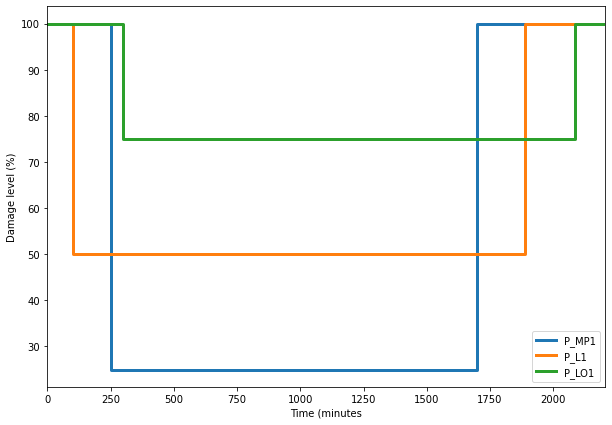

In [31]:
#Plotting repair curves
plots.plot_repair_curves(motor_failure, scatter = False)

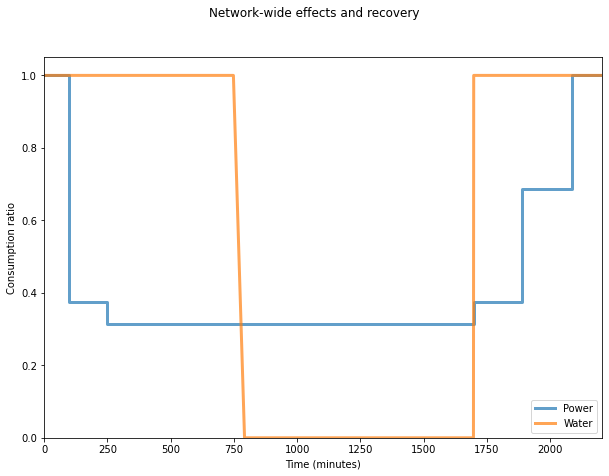

In [17]:
plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker)

In [28]:
location = MAIN_DIR/f'dreaminsg_integrated_model/disruptive_scenarios/test1/'
simulation.write_results(
    time_tracker, power_consump_tracker, water_consump_tracker, location, plots=False
)

FileNotFoundError: [Errno 2] No such file or directory: '..\\dreaminsg_integrated_model\\disruptive_scenarios\\test1\\motor_failure.csv'